# ĐỒ ÁN NHÓM: MÔ HÌNH THỜI TIẾT (CLIMATE MODEL)

## Thông tin nhóm:

| Họ và tên      | MSSV |
| ----------- | ----------- |
| Phan Minh Triết      | 19120039 |
| Trần Đức Thuỵ   | 19120138 |

## Import các thư viện cần thiết

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
sns.set()

## 1. Xây dựng mô hình thời tiết cơ bản:

### Đọc dữ liệu từ file data.txt:

In [48]:
df = pd.read_csv("data.txt", sep="     ", engine="python")
df

,Year,No_Smoothing,Lowess
0,1880,-0.16,-0.09
1,1881,-0.08,-0.12
2,1882,-0.10,-0.16
3,1883,-0.17,-0.20
4,1884,-0.28,-0.23
...,...,...,...
137,2017,0.92,0.91
138,2018,0.85,0.92
139,2019,0.98,0.93
140,2020,1.02,0.94


### Kiểm tra kích thước dữ liệu:
Dữ liệu có **142 dòng** và **3 thuộc tính**

In [49]:
df.shape

(142, 3)

#### Thông tin các cột dữ liệu:
* `Year`: năm
* `No_smoothing`: nhiệt độ trung bình của trái đất trong năm chưa được làm trơn
* `Lowess`: số liệu nhiệt độ sau khi đã làm trơn

### Kiểm tra số lượng phần tử Nan ở các cột

In [50]:
df.isna().sum()

Year            0
No_Smoothing    0
Lowess          0
dtype: int64

* Không tồn tại dữ liệu nan ở bất kì cột nào

### Kiểm tra các dòng có trùng lặp hay không?

In [51]:
df.duplicated().sum()

0

Ta thấy không có dữ liệu trùng.

### Kiểm tra kiểu dữ liệu
* `Year`: số nguyên
* `No_Smooth và Lowess`: số thực
* `Kiểu dữ liệu` phù hợp

In [52]:
df.dtypes

Year              int64
No_Smoothing    float64
Lowess          float64
dtype: object

### Trực quan dữ liệu

In [53]:
plt.figure(figsize=(15,8))
fig = px.line(df,x="Year",y=["No_Smoothing","Lowess"])
fig.show()

<Figure size 1080x576 with 0 Axes>

In [54]:
def T(year):
    if(year == 1850):
        return -0.5
    else:
        temp_previous_year = T(year-1)
        c = 51 
        S = 1368
        alpha = 0.3
        B = 1.3
        n = year - 1850
        k = (1+(n/220)**3)
        k_ch4 = (203.124 -0.316*n + 0.00018*(n**2))/203.124
        result = ((S*(1-alpha)/4)/c + B*(-0.5-temp_previous_year) + 
                  5*np.log(k/280)) + temp_previous_year
        return result

In [55]:
def scale_T(year):
    k = T(year)
    return k + 18

In [56]:
predict_temp = []
year = list(range(1880,2022))
for i in year:
    predict_temp.append(scale_T(i))
predict_temp = np.array(predict_temp)

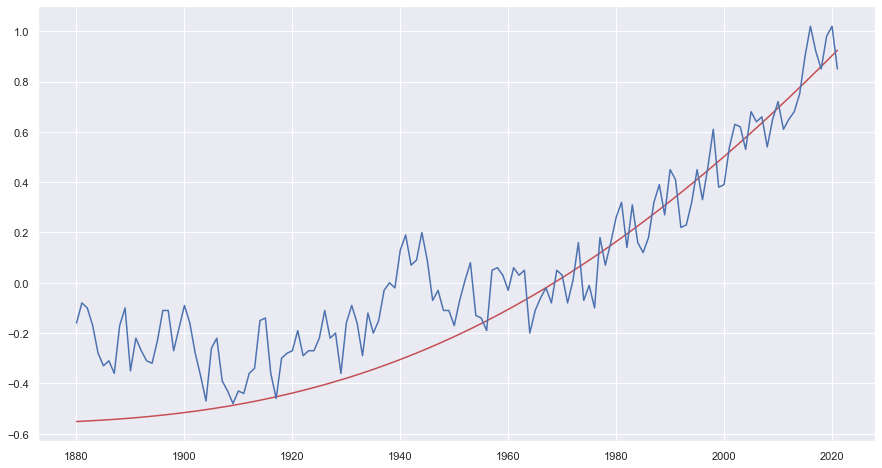

In [57]:
plt.figure(figsize=(15,8))
plt.plot(year,predict_temp, c='r')
plt.plot(df.Year, df.No_Smoothing,c='b')

Dự đoán vào năm 2030:

In [58]:
scale_T(2030)

1.1237251947816702

In [59]:
MSE = np.square(np.subtract(df.No_Smoothing, predict_temp)).mean()
MSE

0.04094330580134907

## 2. Improve climate model:

Ở đây em sẽ sử dụng hàm khí thải CH4.

In [60]:
df_ch4 = pd.read_csv("ch4.csv")
df_ch4 = df_ch4[0:50]

Để tìm giá trị CH4 Concenation em sẽ sử dụng dataset "CH4 pulse" trên trang web [carbonator.org]. Sau đó áp dụng mô hình **Polynomial Regression** để tìm mối liên hệ từ đó sẽ tìm được giá trị mà ứng với mỗi t năm CH4 sẽ tăng bao nhiêu lần.

Text(0, 0.5, 'Each dt year')

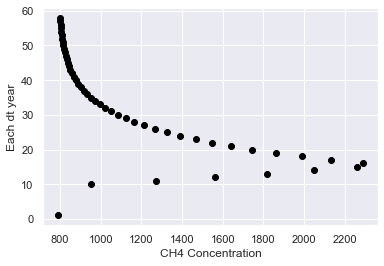

In [82]:
X = df_ch4[["CH4 Concentration"]]
y = df_ch4["dataset"]
# Produce a scatter graph of Humidity against Pressure
plt.scatter(X, y, c = "black")
plt.xlabel("CH4 Concentration")
plt.ylabel("Each dt year")

Áp dụng mô hình **Polynomial Regression** với bậc 3

In [83]:
pre_process = PolynomialFeatures(degree=3)

X_poly = pre_process.fit_transform(X)

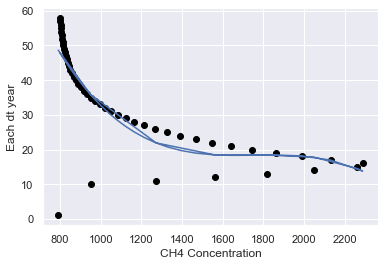

In [84]:
pr_model = LinearRegression(fit_intercept=False)

pr_model.fit(X_poly, y)

y_pred = pr_model.predict(X_poly)

plt.scatter(X, y, c = "black")
plt.xlabel("CH4 Concentration")
plt.ylabel("Each dt year")
plt.plot(X, y_pred)

In [85]:
theta0, theta1, theta2, theta3 = pr_model.coef_
np.set_printoptions(suppress=True)
theta0, theta1, theta2

(203.12403052275823, -0.31649696636197305, 0.0001802232441686802)

In [86]:
def T_optimize(year):
    if(year == 1850):
        return -0.5
    else:
        temp_previous_year = T(year-1)
        c = 51 
        S = 1368
        alpha = 0.3
        B = 1.3
        n = year - 1850
        k = (1+(n/220)**3)
        k_ch4 = (203.124 -0.316*n + 0.00018*(n**2))/203.124
        result = ((S*(1-alpha)/4)/c + B*(-0.5-temp_previous_year) + 
                  5*np.log(k/280)) + 0.66*np.log(k_ch4/0.715) + temp_previous_year
        return result

In [87]:
def scale_T_optimize(year):
    k = T_optimize(year)
    return k + 18

In [88]:
predict_optimize = []
year = list(range(1880, 2022))
for i in year:
    predict_optimize.append(scale_T_optimize(i))
predict_optimize = np.array(predict_optimize)

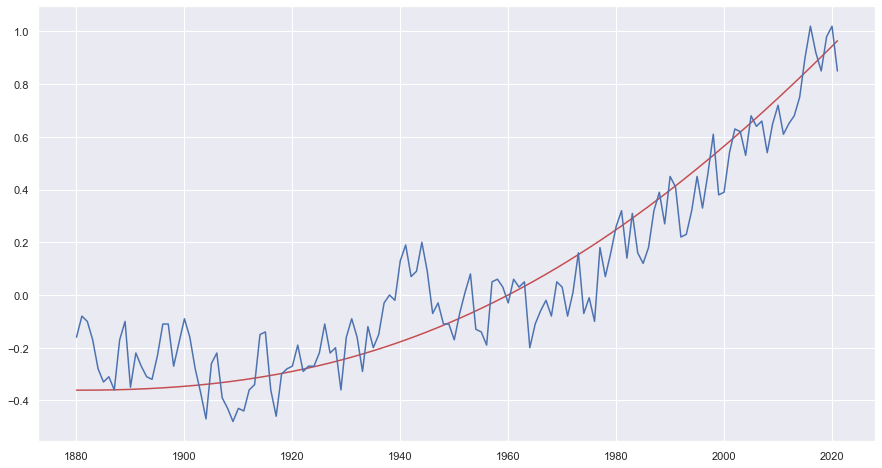

In [89]:
plt.figure(figsize=(15,8))
plt.plot(year,predict_optimize, c='r')
plt.plot(df.Year, df.No_Smoothing,c='b')

In [90]:
MSE_optimized = mean_squared_error(predict_optimize,df.No_Smoothing)
MSE_optimized

0.017961619722804915

In [91]:
# Du doan vao nam 2030
scale_T_optimize(2030)

1.1541092862211926

## 3. Nhận xét và đánh giá:

- Nhóm đã xây dựng thành công mô hình thời tiết cơ bản và cải thiện mô hình bằng khí thải CH4.
- Ta thấy MSE giữa Mô hình cải tiến với khí CH4 < MSE Mô hình thời tiết cơ bản cho thấy việc optimize bằng cách thêm phương trình vi phân khí CH4 thải ra là có hiệu quả

- Mô hình đã được cải tiến thành công với MSE nhỏ hơn.

- Nhiệt độ Trái Đất vào năm 2030 là **1.154103 (độ C)**

## Phương trình nhiệt độ Trái Đất
$$y_{n+1} - y_n =  \dfrac{S\times (1-alpha)}{4\times c} + B \times (1-y_n) + 5 \times \log \dfrac{k}{280} + 0.66 \times \log \dfrac{k_{ch4}}{0.715}$$

$y_{n}$:   Temperature in n_th (from 1850)

$alpha$:   Alberto or plentary reflectivity (0.3)

$c$: atmosphere and upper-ocean heat capacity ($51J/m_{2}/C$)

$B = 1.3W/$$m^{2}$$/C$

$k = $$1+(\frac{n}{220})^3$:   forcing coefficient

$k_{ch4} = \dfrac{(203.124 - 0.316 \times n + 0.00018 \times n^2)}{203.124}$:    CH4 Concentration

## 4. Tài liệu tham khảo:

- Bài giảng của thầy Nguyễn Ngọc Đức.
- Dataset tại trang web Carbonator.org với Scenario là **CH4 Pulse**
- Tìm hiểu về CH4 tại bài báo khoa học: [CH4 Emission](https://iopscience.iop.org/article/10.1088/1748-9326/4/4/044007/pdf)

                                                --- HẾT ---